Sample script for MNLab2BICN.

メディアネットワーク実験IIB 項目Iで利用するサンプル．

PSK および QAM は適切に実装されていません．
`# Start of 要修正` から `# End of 要修正` の箇所を修正する必要があります．
なお，行中の一部を修正すれば良いというわけではなく，
必要に応じて行の追加が必要になります．

必要なファイルを`github`から取り出す．

In [2]:
!test -d mnlab2bicn && (cd mnlab2bicn ; git pull) || git clone https://github.com/htsutsui/mnlab2bicn/
!cp mnlab2bicn/mnlab2bicn.py .
!cp mnlab2bicn/gray.py .

Cloning into 'mnlab2bicn'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 128 (delta 70), reused 87 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 30.72 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (70/70), done.


`mnlab2bicn`が依存する`gmpy2` (BER計算を高速化する)をインストールする．
なお，`gmpy2`が無くてもBER計算は可能(若干遅くなる)なので，エラーが生じる場合は無視すること．

In [3]:
!sudo apt-get update
!sudo apt-get install -y libgmp-dev libmpfr-dev libmpc-dev
!pip install gmpy2

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,448 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/ma

NumPy と Matplotlib を使うので`import`する．

In [4]:
import matplotlib.pyplot as plt
import numpy as np

実験で使用するあらかじめ用意されている関数を`import`する．

In [5]:
from mnlab2bicn import awgn, calc_ser, calc_ber, \
    int2gray, gray2int, scatter_plot

このscript中で利用するdebug用の変数．

In [6]:
verbose = True # True だと for loop の処理の状況(進み具合)が確認できる
verbose_awgn = False

PSKのシミュレーションを行う関数を定義する．

In [7]:
def psk_test(m_level, i_snr, i_size, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src

    # Start of 要修正
    y = np.exp(1j*2*np.pi/m_level*x)
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    z = np.angle(y_noisy)
    z = z/(2*np.pi/m_level)
    z = z.round()
    z = np.array(z.round(), dtype='int')
    z = np.where(z<0, z+m_level, z)

    # z = np.round(y_noisy.real * (m_level - 1))
    # z = np.where(z < 0, 0, z)
    # z = np.where(z > m_level - 1, m_level - 1, z)
    # End of 要修正

    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

QAMのシミュレーションを行う関数を定義する．

In [8]:
def qam_test(m_level, i_snr, i_size, plot=False, gray=False):
    """QAM test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)
    k = int(np.log2(m_level))
    smax = 2 ** (k // 2) - 1

    yr = src >> (k // 2)
    yi = src & smax

    yr = int2gray(yr) if gray else yr
    yi = int2gray(yi) if gray else yi

    # Start of 要修正
    xr = 2 * yr - smax
    xi = 2 * yi - smax
    y = (xr + 1j * xi) / smax

    # y = np.exp(1j * (2 * np.pi) / (smax + 1) * yr)
    # y *= ((yi + 1) / (smax + 1))
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"QAM_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    xr_noisy = np.round(np.real(y_noisy) * smax)
    xi_noisy = np.round(np.imag(y_noisy) * smax)

    # zr = np.round(np.angle(y_noisy)/((2 * np.pi) / (smax + 1)))
    # zr += (zr < 0)*(smax + 1)
    # zr = np.array(zr, dtype='int')

    zr = ((xr_noisy + smax) / 2).astype(int)
    zi = ((xi_noisy + smax) / 2).astype(int)



    # zi = np.round(np.abs(y_noisy) * (smax + 1))
    # zi = np.array(zi, dtype='int')
    # zi -= 1
    # End of 要修正

    zr = np.where(zr < 0, 0, zr)
    zr = np.where(zr > smax, smax, zr)
    zi = np.where(zi < 0, 0, zi)
    zi = np.where(zi > smax, smax, zi)

    zr = gray2int(zr) if gray else zr
    zi = gray2int(zi) if gray else zi

    dst = zr << (k // 2)
    dst += zi

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

グラフのフォントサイズを調整する．

In [9]:
plt.rcParams.update({'font.size': 16})

PSKのシミュレーションを行う．図は`PSK_4_30_100.png`および`PSK_4_30_100.pdf`に保存される．以下同様．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0, 0.0)

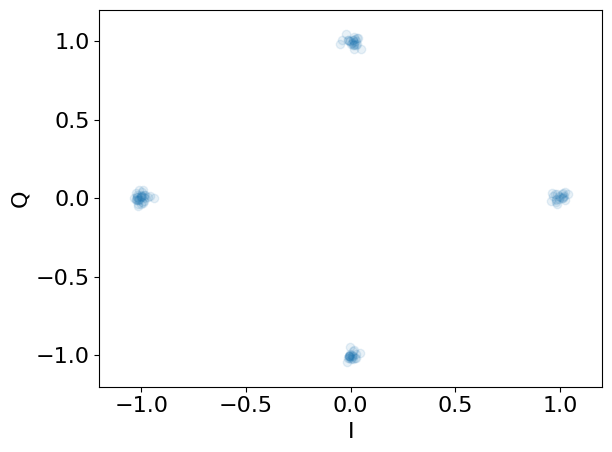

In [10]:
psk_test(4, 30, 100, plot=True)

(0.0, 0.0)

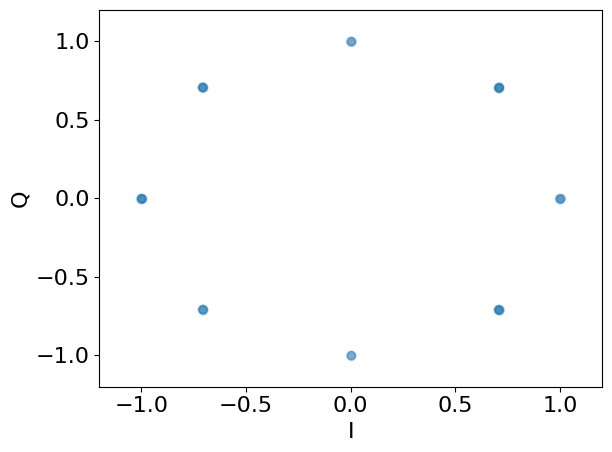

In [11]:
psk_test(8, 50, 100, plot=True)

(0.0, 0.0)

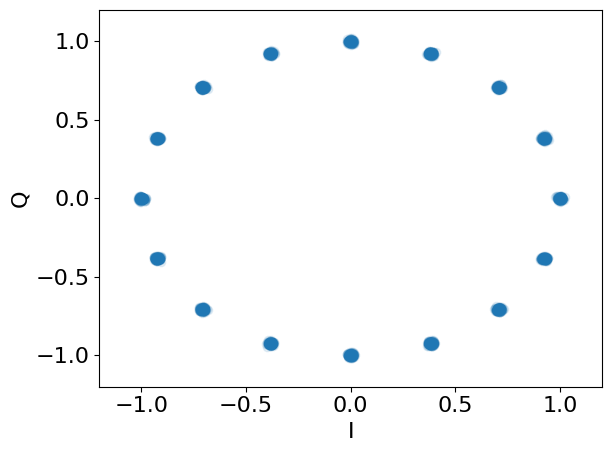

In [12]:
psk_test(16, 40, 4000, plot=True)

QAMのシミュレーションを行う．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0, 0.0)

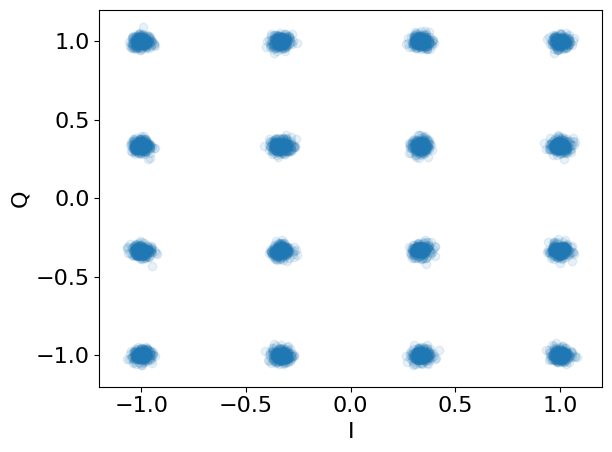

In [13]:
qam_test(16, 30, 4000, plot=True)

(0.0005, 0.000125)

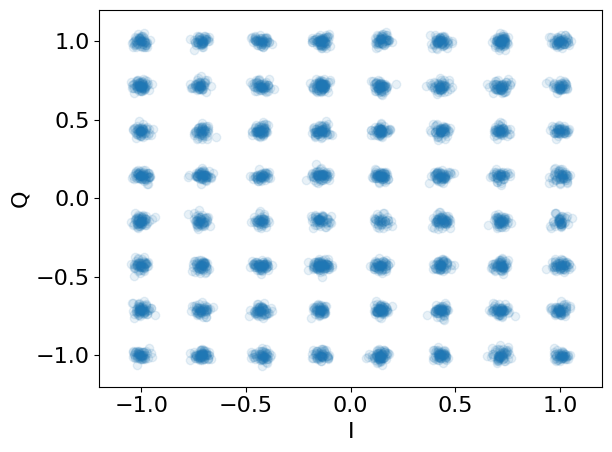

In [14]:
qam_test(64, 30, 4000, plot=True)

グラフのフォントサイズを調整する．

In [15]:
psk_test(4, 0, 20000)

(0.2928, 0.212425)

In [16]:
psk_test(4, 4, 20000)

(0.11175, 0.08295)

In [17]:
psk_test(4, 8, 20000)

(0.0103, 0.008)

In [18]:
psk_test(4, 12, 20000)

(5e-05, 2.5e-05)

In [19]:
psk_test(8, 0, 20000)

(0.5765, 0.32975)

In [20]:
psk_test(8, 4, 20000)

(0.38965, 0.22651666666666667)

In [21]:
psk_test(8, 8, 20000)

(0.179, 0.10426666666666666)

In [22]:
psk_test(8, 12, 20000)

(0.03225, 0.018816666666666666)

In [23]:
qam_test(16, 0, 20000)

(0.7511, 0.313)

In [24]:
qam_test(16, 4, 29000)

(0.6162068965517241, 0.2482758620689655)

In [25]:
qam_test(16, 8, 20000)

(0.43895, 0.1676875)

In [26]:
qam_test(16, 12, 20000)

(0.26215, 0.093875)

In [27]:
qam_test(64, 0, 20000)

(0.92305, 0.3641)

In [28]:
qam_test(64, 4, 20000)

(0.874, 0.32460833333333333)

In [29]:
qam_test(64, 8, 20000)

(0.77565, 0.26748333333333335)

In [30]:
qam_test(16, 12, 20000)

(0.2675, 0.09675)

(9e-05, 6.5e-05)

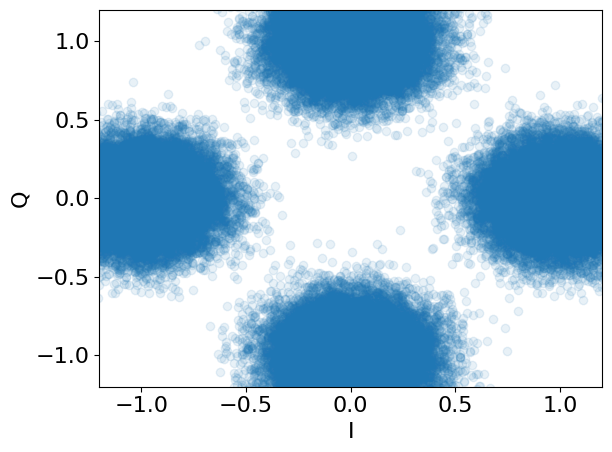

In [31]:
#実験2 (2)
psk_test(4, 12, 100000, plot = True)

In [32]:
plt.rcParams.update({'font.size': 12})

PSK/QAM Comparison

課題3．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.9431833333333334, 0.42231944444444447]
[2, 64, 0.93023, 0.4026661111111111]
[4, 64, 0.9129066666666666, 0.3790672222222222]
[6, 64, 0.8893233333333334, 0.35368944444444445]
[8, 64, 0.86138, 0.3289588888888889]
[10, 64, 0.82592, 0.30205944444444444]
[12, 64, 0.7830433333333333, 0.27633166666666664]
[14, 64, 0.72792, 0.24832555555555555]
[16, 64, 0.66034, 0.22040055555555554]
[18, 64, 0.5797366666666667, 0.19060777777777776]
[20, 64, 0.48845666666666665, 0.16016944444444445]
[22, 64, 0.3824266666666667, 0.12589444444444445]
[24, 64, 0.27009333333333335, 0.08848611111111111]
[26, 64, 0.16544666666666666, 0.054468888888888886]
[28, 64, 0.08168, 0.026656666666666665]
[30, 64, 0.02839, 0.009268888888888889]
[32, 64, 0.005866666666666667, 0.0019266666666666666]
[34, 64, 0.0005366666666666666, 0.00016444444444444444]
[36, 64, 1.6666666666666667e-05, 6.111111111111111e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.92405, 0.36456]
[2, 64, 0.9022266666666666, 0.3442327777777778]
[4, 64, 0.8726166666

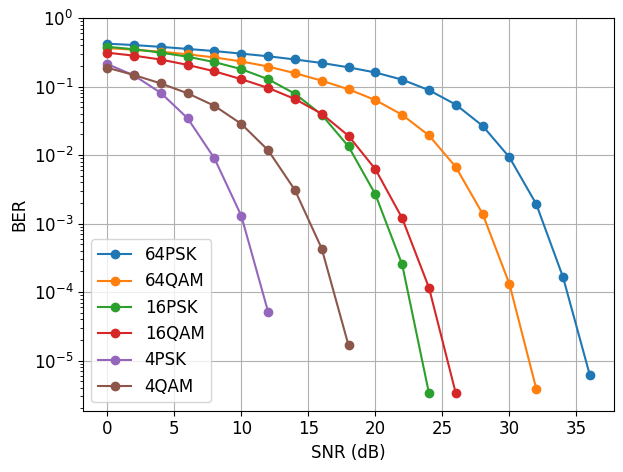

In [38]:
size = 300000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_QAM.png")
plt.savefig("PSK_QAM.pdf")

(0.0, 0.0)

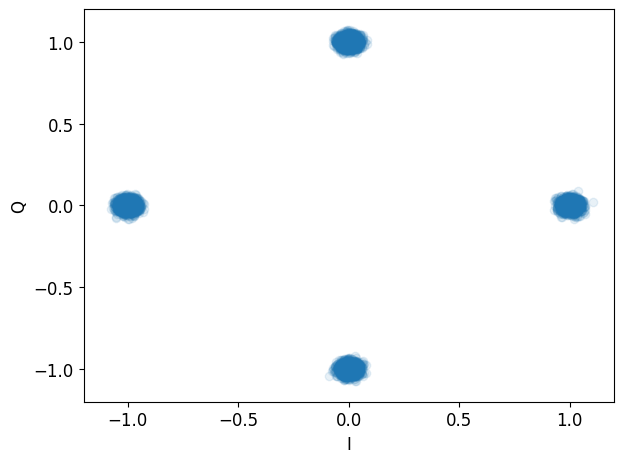

In [52]:
psk_test(4, 30, 10000, plot = True)

(0.0, 0.0)

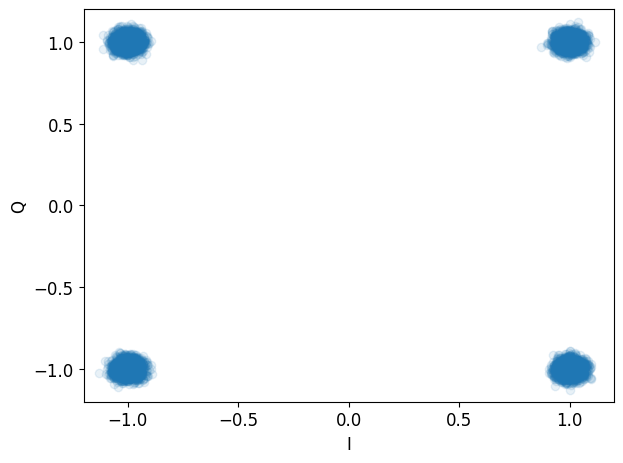

In [53]:
qam_test(4, 30, 10000, plot = True)

(0.0, 0.0)

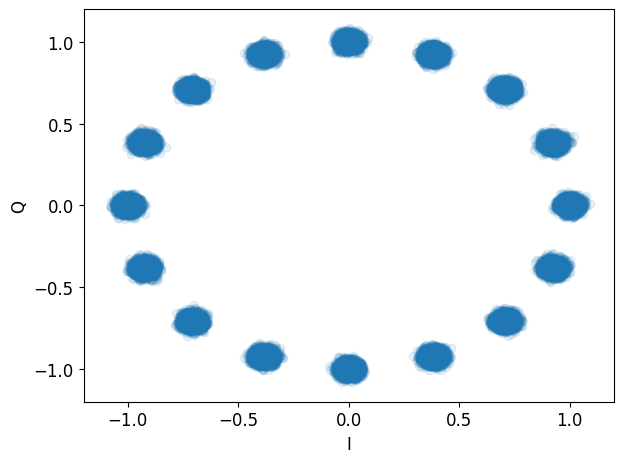

In [43]:
psk_test(16, 30, 100000, plot = True)

(0.0, 0.0)

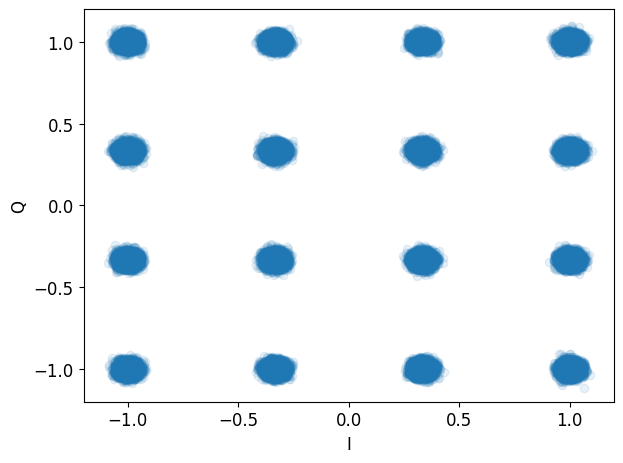

In [45]:
qam_test(16, 30, 100000, plot = True)

(0.0, 0.0)

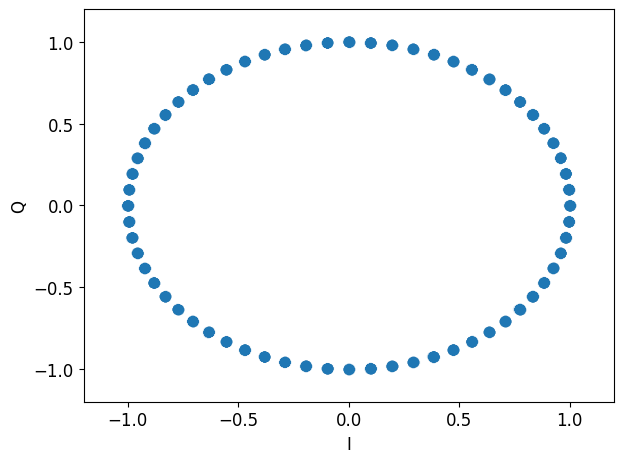

In [54]:
psk_test(64, 50, 10000, plot = True)

(0.0003, 0.0001)

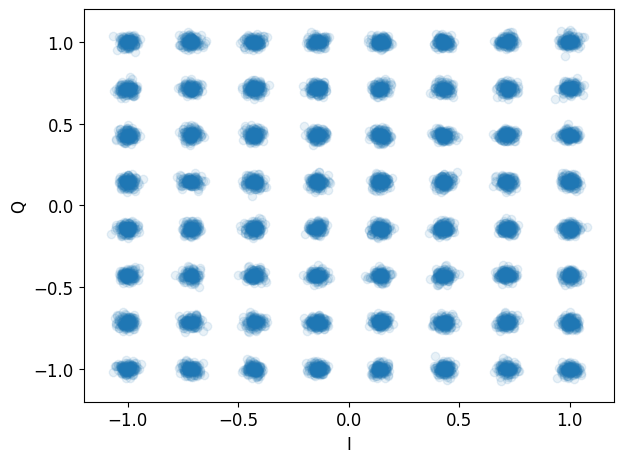

In [51]:
qam_test(64, 30, 10000, plot = True)

PSK Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.94316, 0.4215244444444444]
[2, 64, 0.9303866666666667, 0.40140722222222225]
[4, 64, 0.9120766666666666, 0.3782377777777778]
[6, 64, 0.8899133333333333, 0.35388833333333336]
[8, 64, 0.8620533333333333, 0.3280822222222222]
[10, 64, 0.8262933333333333, 0.3020138888888889]
[12, 64, 0.7822733333333334, 0.27609222222222224]
[14, 64, 0.72755, 0.2485961111111111]
[16, 64, 0.6609433333333333, 0.22016388888888888]
[18, 64, 0.58039, 0.1905477777777778]
[20, 64, 0.48625, 0.159865]
[22, 64, 0.38327333333333335, 0.12592277777777777]
[24, 64, 0.2708966666666667, 0.08864277777777778]
[26, 64, 0.16716333333333333, 0.054805]
[28, 64, 0.08057333333333333, 0.026401666666666667]
[30, 64, 0.028073333333333332, 0.009105]
[32, 64, 0.00583, 0.0019088888888888888]
[34, 64, 0.00042, 0.00013444444444444444]
[36, 64, 1e-05, 3.3333333333333333e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.9422733333333333, 0.38151833333333335]
[2, 64, 0.9303366666666667, 0.3582722222222222]
[4, 64, 0.9125333333333333, 0.33175]
[6, 64

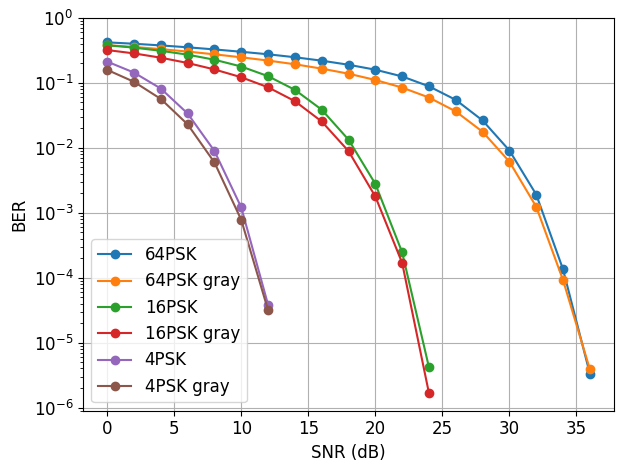

In [62]:
size = 300000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_gray.png")
plt.savefig("PSK_gray.pdf")

QAM Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.9243466666666666, 0.36423944444444445]
[2, 64, 0.90358, 0.3454211111111111]
[4, 64, 0.8720166666666667, 0.3220266666666667]
[6, 64, 0.8283966666666667, 0.2950272222222222]
[8, 64, 0.77126, 0.2656672222222222]
[10, 64, 0.6984833333333333, 0.23194555555555554]
[12, 64, 0.6088466666666666, 0.19473]
[14, 64, 0.51093, 0.1571061111111111]
[16, 64, 0.4100433333333333, 0.12135888888888889]
[18, 64, 0.31604666666666664, 0.09040166666666667]
[20, 64, 0.22724333333333332, 0.06319888888888889]
[22, 64, 0.14413333333333334, 0.03917333333333333]
[24, 64, 0.07119333333333333, 0.019021666666666666]
[26, 64, 0.02534, 0.006606111111111111]
[28, 64, 0.00534, 0.00142]
[30, 64, 0.00044666666666666666, 0.00012222222222222221]
[32, 64, 1.3333333333333333e-05, 4.444444444444444e-06]
[34, 64, 0.0, 0.0]
[0, 64, 0.9249966666666667, 0.3599861111111111]
[2, 64, 0.9017566666666667, 0.3230622222222222]
[4, 64, 0.8728666666666667, 0.28688]
[6, 64, 0.8288133333333333, 0.24930833333333333]
[8, 64, 0.771756666

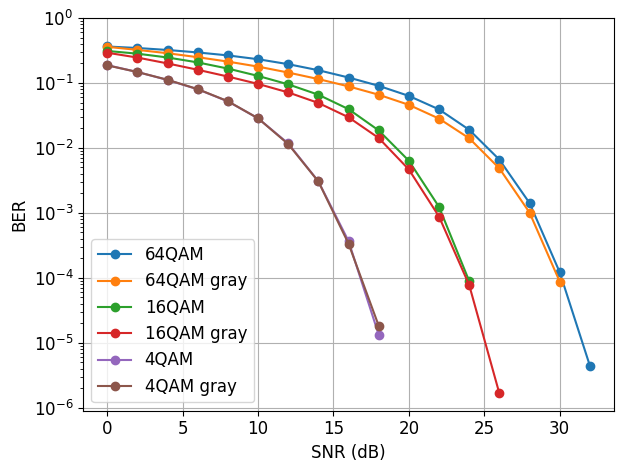

In [64]:
size = 300000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("QAM_gray.png")
plt.savefig("QAM_gray.pdf")